# **Importing the libraries**

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
import random
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# **Defining the constants**

In [2]:
IMG_SIZE = 128
BATCH_SIZE = 32
BUFFER_SIZE = 1000
OUTPUT_CHANNELS = 2

# **Loading and Splitting the dataset**

In [3]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)
train_dataset = dataset['train']
test_dataset = dataset['test']

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

I0000 00:00:1751060297.071998      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751060297.072737      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.RT4ANU_4.0.0/oxford_iiit_pet-train.tfrecord*...…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/incomplete.RT4ANU_4.0.0/oxford_iiit_pet-test.tfrecord*...:…

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/4.0.0. Subsequent calls will reuse this data.


# **Normalising the data**

In [4]:
def normalize(input_image, input_mask):
    input_image = tf.image.resize(input_image, (IMG_SIZE, IMG_SIZE))
    input_mask = tf.image.resize(input_mask, (IMG_SIZE, IMG_SIZE), method='nearest')
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask = tf.cast(input_mask, tf.int32)
    input_mask = tf.where(input_mask == 1, 1, 0)
    return input_image, input_mask

In [5]:
def load_data(datapoint):
    return normalize(datapoint['image'], datapoint['segmentation_mask'])

# **Mapping dataset transformation**

In [6]:
train = train_dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
test = test_dataset.map(load_data)

train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().prefetch(tf.data.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

# **Building the model architecture**

In [7]:
def conv_block(input_tensor, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same", activation="relu")(input_tensor)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding="same", activation="relu")(x)
    return x

In [8]:
def encoder_block(input_tensor, num_filters):
    x = conv_block(input_tensor, num_filters)
    p = tf.keras.layers.MaxPooling2D((2, 2))(x)
    return x, p

In [9]:
def decoder_block(input_tensor, skip_tensor, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input_tensor)
    x = tf.keras.layers.Concatenate()([x, skip_tensor])
    x = conv_block(x, num_filters)
    return x

# **Building the U-NET Model**

In [10]:
def unet_model(output_channels):
    inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    b1 = conv_block(p4, 1024)
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)
    outputs = tf.keras.layers.Conv2D(OUTPUT_CHANNELS, (1, 1), activation='softmax')(d4)
    return tf.keras.Model(inputs, outputs)

In [11]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
steps_per_epoch = info.splits['train'].num_examples // BATCH_SIZE

# **Training the model**

In [13]:
history = model.fit(train_dataset, epochs=40, steps_per_epoch=steps_per_epoch, validation_data=test_dataset)

Epoch 1/40


I0000 00:00:1751060361.293896     122 service.cc:148] XLA service 0x7d958c00b7c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751060361.294749     122 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751060361.294768     122 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1751060361.780196     122 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1751060362.224263     122 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1751060407.705596     122 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step - accuracy: 0.6857 - loss: 0.7830

W0000 00:00:1751060459.758018     120 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1751060499.238399     123 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


115/115 ━━━━━━━━━━━━━━━━━━━━ 164s 940ms/step - accuracy: 0.6858 - loss: 0.7821 - val_accuracy: 0.7001 - val_loss: 0.5285
Epoch 2/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 655ms/step - accuracy: 0.7425 - loss: 0.4802 - val_accuracy: 0.8068 - val_loss: 0.4129
Epoch 3/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 655ms/step - accuracy: 0.8024 - loss: 0.4222 - val_accuracy: 0.8064 - val_loss: 0.4160
Epoch 4/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 655ms/step - accuracy: 0.8148 - loss: 0.4027 - val_accuracy: 0.8431 - val_loss: 0.3568
Epoch 5/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 76s 660ms/step - accuracy: 0.8420 - loss: 0.3597 - val_accuracy: 0.8644 - val_loss: 0.3147
Epoch 6/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 75s 658ms/step - accuracy: 0.8623 - loss: 0.3186 - val_accuracy: 0.8744 - val_loss: 0.2899
Epoch 7/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 76s 661ms/step - accuracy: 0.8766 - loss: 0.2889 - val_accuracy: 0.8825 - val_loss: 0.2738
Epoch 8/40
115/115 ━━━━━━━━━━━━━━━━━━━━ 76s 665ms/step - accuracy: 0.8902 - loss: 0.2608 - va

# **Visualizing the Model's Training History**

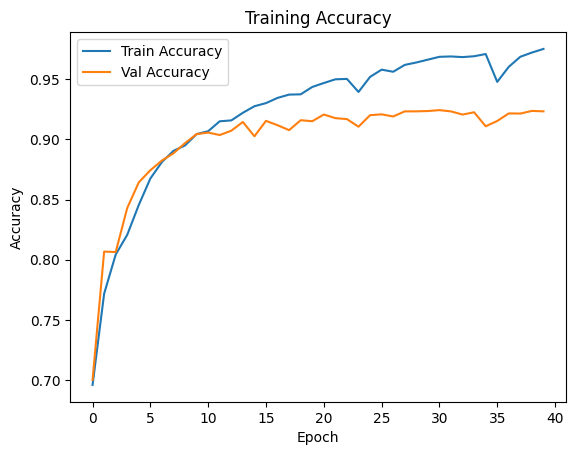

In [14]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training Accuracy')
plt.show()

# **Evaluating the model using Confusion Matrix and Classification Report**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

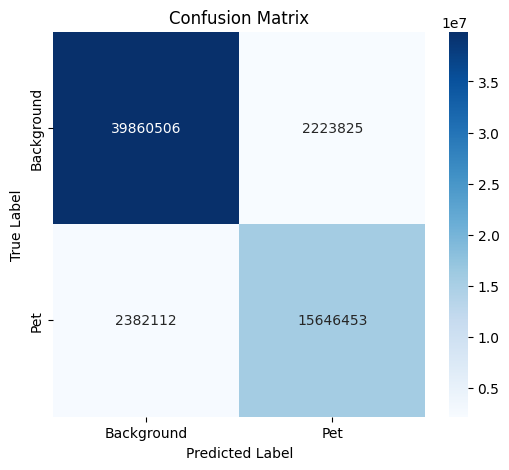

In [15]:
y_true = []
y_pred = []

for images, masks in test_dataset:
    preds = model.predict(images)
    preds = tf.argmax(preds, axis=-1).numpy().flatten()
    masks = tf.reshape(masks, [-1]).numpy()
    y_pred.extend(preds)
    y_true.extend(masks)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_true, y_pred)
class_names = ['Background', 'Pet']
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# **Visualizing Model Predictions**

In [16]:
def display(display_list):
    plt.figure(figsize=(15, 5))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

In [17]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask

In [18]:
def show_predictions(dataset, num=3):
    count = 0
    for images, masks in dataset:
        preds = model.predict(images)
        for i in range(len(images)):
            display([images[i], masks[i], create_mask(preds[i])])
            count += 1
            if count >= num:
                return

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step


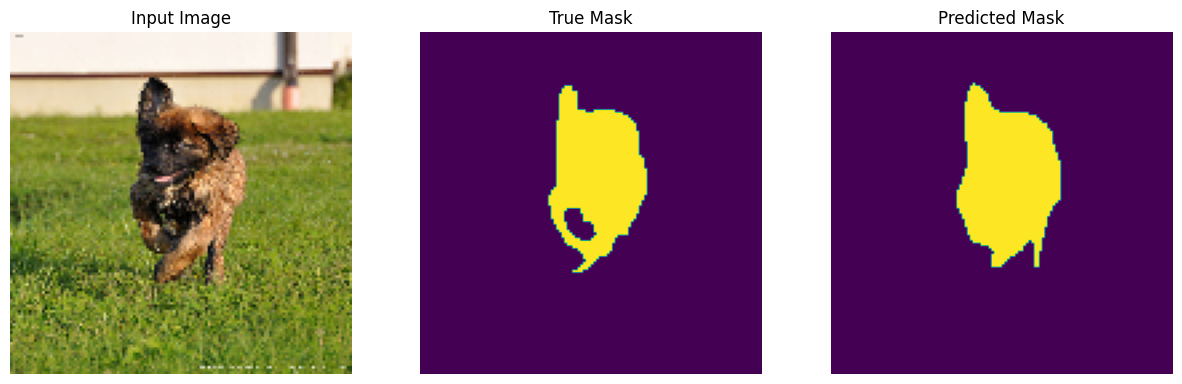

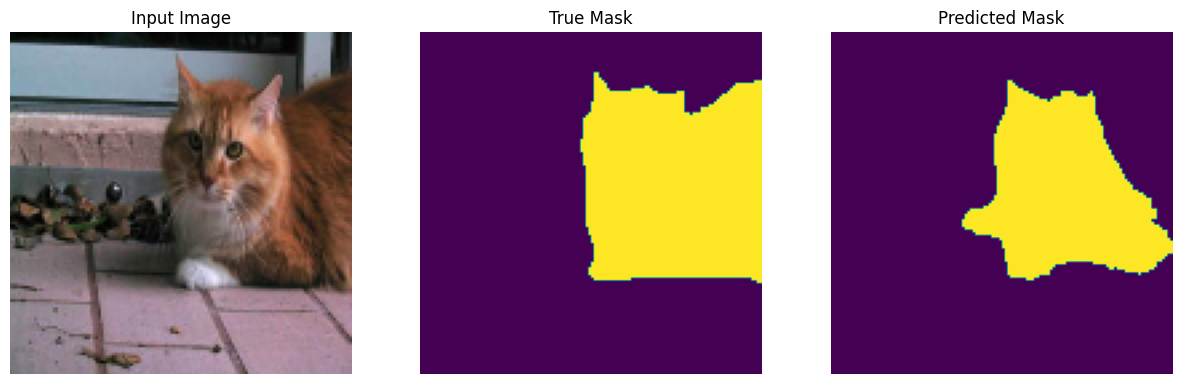

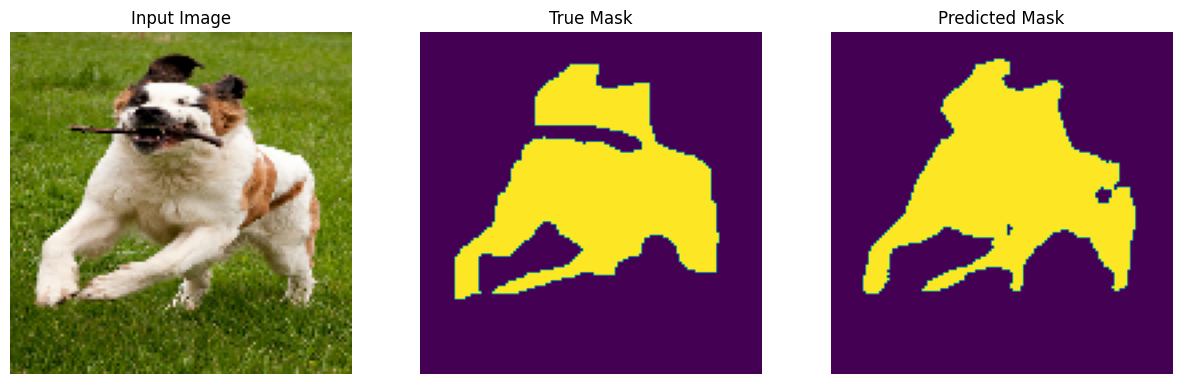

In [19]:
show_predictions(test_dataset, num=3)